# Imports

In [1]:
# Python standard library
import sys
import csv

# Scientific computing
import numpy as np
import cv2
import matplotlib.pyplot as plt
import scipy.ndimage

# Program specific
sys.path.append('/home/prestonh/Desktop/Research/pore_stats/pore_stats/rp/')
sys.path.append('/home/prestonh/Desktop/Research/pore_stats/pore_stats/oi/')
import resistive_pulse as rp
import rp_file
import optical_imaging as oi
import oi_file


# Jupyter
from IPython.display import HTML

# Load data

In [2]:
date = '10-10-2017/'
particle = 'HCT-116_1/'
channel = '10-20-10_1/'
file_index = '0'

base_path = '/home/prestonh/Desktop/Research/cancer_cells/data/'

oi_vid_file_path = base_path + date + particle + channel + 'oi/bin/test_camera_' + file_index
oi_events_file_path = base_path + date + particle + channel + 'oi/events/test_camera_' + file_index + '_events.json'

In [3]:
# Load video
res_x = 384
res_y = 112
oi_fps = 250000

oi_vid = oi_file.Video(oi_vid_file_path, res_x, res_y, oi_fps)

# Load events
oi_events = oi_file.open_event_file_json(oi_events_file_path)

/home/prestonh/Desktop/Research/pore_stats/pore_stats/oi/optical_imaging.py:75: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if pixels != None:


In [4]:
print len(oi_events)

1140


##### Load ellipses

In [5]:
oi_ellipse_base_path = '../data/'
oi_ellipse_path = oi_ellipse_base_path + date + particle + channel + file_index + '/ellipses'

ellipsess = []


with open(oi_ellipse_path, 'r') as file_handle:
    file_reader = csv.reader(file_handle, delimiter = '\t')
    
    # Skip header
    header_length = 2
    for i in range(header_length):
        next(file_reader)
        
        
    for row in file_reader:
        
        if row[0] == 'event #':
            # New event
            ellipsess.append([])
            continue
            
        else:
            ellipse = []
            for ele in row:
                try:
                    ellipse.append(float(ele))
                except:
                    ellipse.append(0)
                    
            ellipsess[-1].append(ellipse)

# Load template and create stage

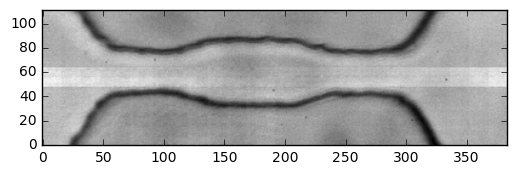

In [6]:
template_index = 100

template_frame = oi_vid.get_frame(template_index)

plt.imshow(template_frame, cmap = 'gray', origin = 'lower')
plt.show()

[ 0.00208333  0.99999783]


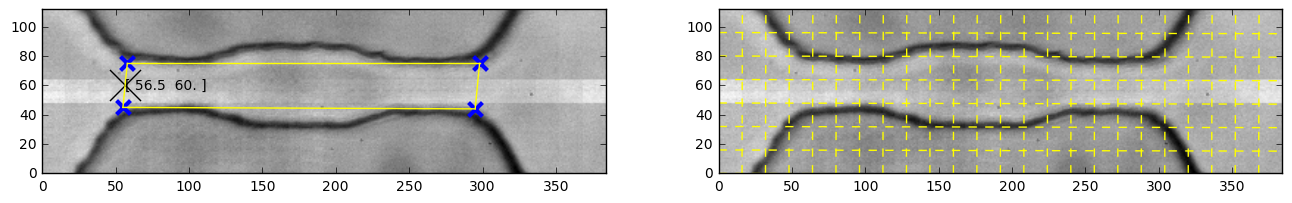

In [7]:
reload(oi)
template_frame = oi_vid.get_frame(template_index)

stage_file_path = base_path + date + particle + channel + 'oi/stage/stage_' + file_index
cs = oi.load_stage_file(stage_file_path)

c0 = cs[0]
c1 = cs[1]
c2 = cs[2]
c3 = cs[3]

oi_stage = oi.Stage(template_frame, c0, c1, c2, c3)
oi_stage.plot_stage()

# Begin filtering

In [8]:
filtering_steps = {}

### Channel enter exit based filtering

In [9]:
keep_indices_enter_exit = []

for i, oi_event in enumerate(oi_events):
    try:
        xs = []
        ys = []

        for j, ellipse in enumerate(ellipsess[i]):
            xs.append(ellipse[1])
            ys.append(ellipse[2])

        xcs, ycs = oi_stage.get_channel_coordinates(xs, ys)
        xcs = oi_stage.pixels_to_meters(xcs)
        ycs = oi_stage.pixels_to_meters(ycs)

        if xcs.min() < 0 and xcs.max() > oi_stage._length_microns:
            keep_indices_enter_exit.append(i)
            
    except:
        # Catch-all: Do not append this element to the keep_indices_enter_exit list;
        #            This will prevent it from being analyzed.
        print 'failed on', i
        pass

In [10]:
filtering_steps['channel enter exit'] = [True]

print 'length before', len(oi_events), 'length after', len(keep_indices_enter_exit)
print
print 'events filtered by entrance/exit', [i for i in range(len(ellipsess)) if i not in keep_indices_enter_exit]

length before 1140 length after 1136

events filtered by entrance/exit [173, 236, 481, 873]


In [19]:
oi_index = 0
reload(oi_file)
plt.close()
HTML(oi_file.make_animation(oi_vid, oi_events[oi_index]._detections[0]._tf, oi_events[oi_index]._detections[-1]._tf, oi_fps).to_html5_video())

## Geometry based filtering

4
49
58
128
151
181
218
220
240
241
260
276
323
326
328
355
358
363
371
390
397
400
410
417
419
427
506
534
554
557
568
572
574
580
591
621
661
682
683
688
690
692
693
719
720
735
762
805
816
828
833
843
846
913
921
932
1049
1054
1087
1109


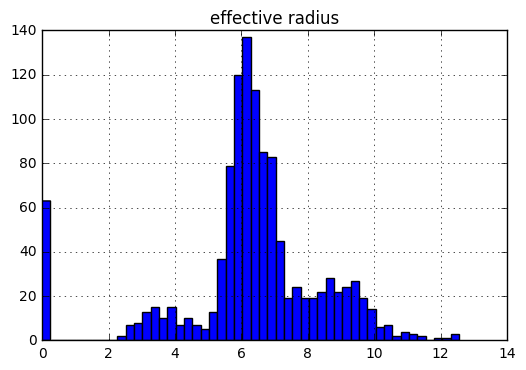

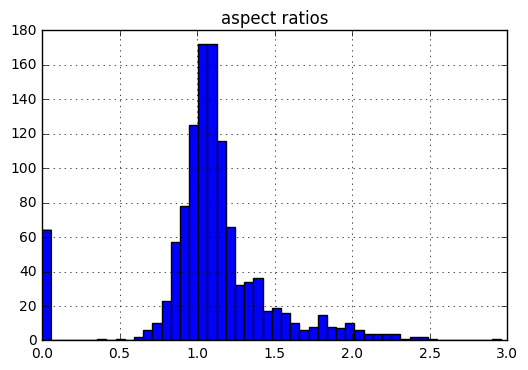

In [31]:
# Define left and right bounds that particle must be between for fitting its radius and aspect
xc_left = -30
xc_right = 0

yc_top = 20
yc_bottom = -20



effective_radii = []
effective_radius_max = 30

aspect_ratios = []
aspect_ratio_max = 3



for i, oi_event in enumerate(oi_events):
  
    aspect_ratio = 0
    effective_radius = 0
    for j, ellipse in enumerate(ellipsess[i]):
        
        x = ellipse[1]
        y = ellipse[2]
        
        xc, yc = oi_stage.get_channel_coordinates(x, y)
        xc = oi_stage.pixels_to_meters(xc)
        yc = oi_stage.pixels_to_meters(yc)
        
        
        
        
        if xc > xc_left and xc < xc_right and yc > yc_bottom and yc < yc_top:
            
            #plt.imshow(oi_vid.get_frame(oi_event._detections[int(ellipse[0])]._tf), cmap = 'gray', origin = 'lower')
            #plt.show()
            
            ax0 = ellipse[3]
            ax1 = ellipse[4]
            
            a = oi_stage.pixels_to_meters(ax0)
            b = oi_stage.pixels_to_meters(ax1)
            
            aspect_ratio = a/b

            effective_radius = np.sqrt(a*b)
        
            break
            
            
    # Catch bad values
    if effective_radius > effective_radius_max or np.isnan(effective_radius) or np.isinf(effective_radius):
        print i
        effective_radius = 0
    
    
    
    if np.isnan(aspect_ratio) or np.isinf(aspect_ratio) or aspect_ratio > aspect_ratio_max:
        aspect_ratio = 0
    
    
        
    # Append values to lists        
    effective_radii.append(effective_radius)
    aspect_ratios.append(aspect_ratio)
    
            
            
plt.hist(effective_radii, bins = 50)
plt.title('effective radius')
plt.grid()
plt.show()
            
plt.hist(aspect_ratios, bins = 50)
plt.title('aspect ratios')
plt.grid()
plt.show()      

## Filter size

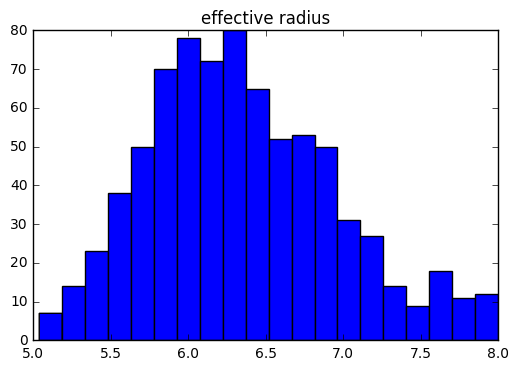

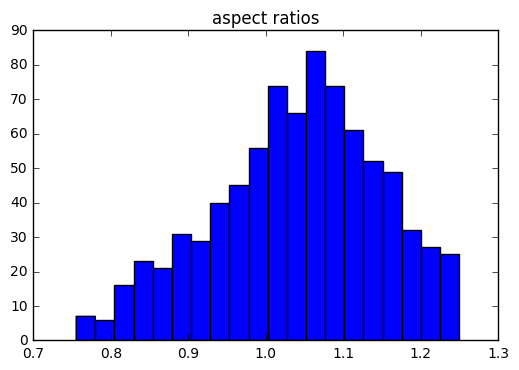

radius filtering 366/1140

indexes sorted by radius
[813, 425, 443, 446, 374, 388, 159, 756, 558, 1074, 82, 93, 991, 465, 101, 608, 1047, 166, 919, 746, 115, 592, 284, 838, 571, 426, 629, 1110, 378, 1006, 904, 847, 887, 367, 298, 223, 406, 96, 213, 849, 911, 509, 1042, 655, 43, 238, 68, 878, 874, 1069, 793, 659, 183, 899, 978, 681, 24, 685, 623, 1057, 329, 1076, 744, 275, 700, 470, 794, 962, 677, 1117, 467, 309, 869, 255, 346, 910, 174, 1089, 675, 119, 45, 809, 271, 297, 553, 270, 994, 971, 508, 90, 206, 348, 280, 973, 432, 179, 766, 960, 931, 549, 149, 1001, 537, 249, 796, 1023, 117, 834, 455, 674, 824, 305, 914, 413, 69, 714, 782, 646, 669, 542, 189, 733, 203, 333, 757, 732, 597, 418, 588, 560, 581, 195, 781, 343, 784, 364, 614, 434, 925, 569, 398, 315, 474, 654, 517, 996, 698, 531, 227, 338, 1038, 187, 100, 232, 547, 767, 718, 729, 616, 480, 1058, 1138, 743, 1097, 807, 291, 360, 660, 937, 947, 229, 759, 806, 734, 1043, 342, 650, 730, 861, 289, 801, 234, 325, 1086, 33, 791, 652, 113,

In [32]:
# Filter size
radius_min = 5
radius_max = 8

filtering_steps['effective radius'] = [radius_min, radius_max]

keep_indices_radius = [i for i in range(len(effective_radii)) if ((effective_radii[i] > radius_min) and (effective_radii[i] < radius_max))]


# Filter aspect

aspect_min = 0.75
aspect_max = 1.25

filtering_steps['aspect ratio'] = [aspect_min, aspect_max]

keep_indices_aspect = [i for i in range(len(aspect_ratios)) if ((aspect_ratios[i] > aspect_min) and (aspect_ratios[i] < aspect_max))]



# Histograms
plt.hist(np.array(effective_radii)[keep_indices_radius], bins = 20)
plt.title('effective radius')
plt.show()
            
plt.hist(np.array(aspect_ratios)[keep_indices_aspect], bins = 20)
plt.title('aspect ratios')
plt.show()  




# Print

print ('radius filtering ' + str(len(oi_events) - len(keep_indices_radius)) + '/' + str(len(oi_events)))

print

print 'indexes sorted by radius\n', [ele for ele in np.argsort(effective_radii) if ele in keep_indices_radius]

print 

print ('aspect ratio filtering ' + str(len(oi_events) - len(keep_indices_aspect)) + '/' + str(len(oi_events)))

print

print 'indexes sorted by aspect\n', [ele for ele in np.argsort(aspect_ratios) if ele in keep_indices_aspect]

print


print ('events filtered by radius (sorted by size):')
effective_radii_tuple = [(i, effective_radii[i]) for i in range(len(effective_radii)) if i not in keep_indices_radius]
print([tuple[0] for tuple in sorted(effective_radii_tuple, key = lambda effective_radius_tuple: effective_radius_tuple[1])])

print

print ('events filtered by aspect:')
print([i for i in range(len(oi_events)) if i not in keep_indices_aspect])

print

print('events filtered out by size but kept by aspect:')
print([i for i in range(len(oi_events)) if (i in keep_indices_aspect) and (i not in keep_indices_radius)])

print


print('events filtered out by aspect but kept by size:')
print([i for i in range(len(oi_events)) if (i not in keep_indices_aspect) and (i in keep_indices_radius)])

print


    


radius: 7.92441651134
aspect: 1.56764826205


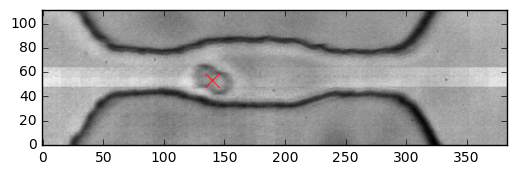

radius: 7.79513798804
aspect: 1.63295275284


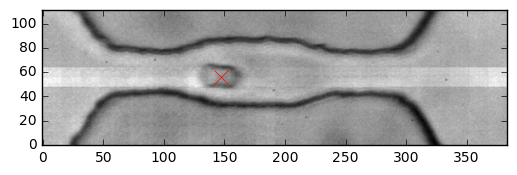

radius: 6.20133396134
aspect: 1.78620744124


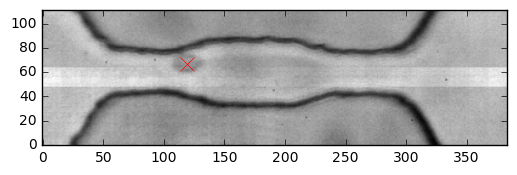

radius: 5.49161605967
aspect: 1.28763228545


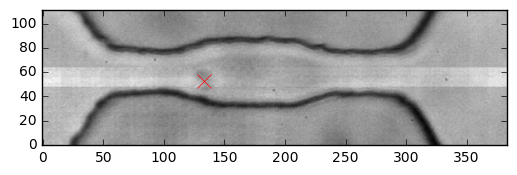

radius: 6.41741575234
aspect: 1.5158173089


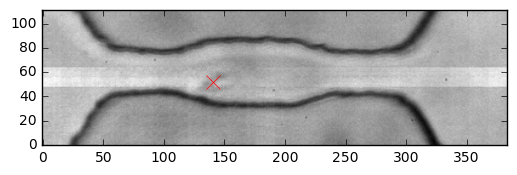

radius: 5.25626784235
aspect: 0.73669081684


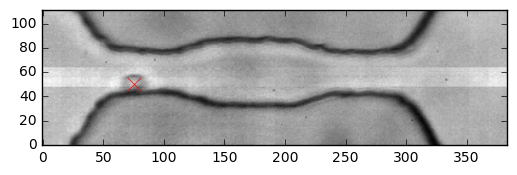

radius: 5.25970014115
aspect: 2.38996025958


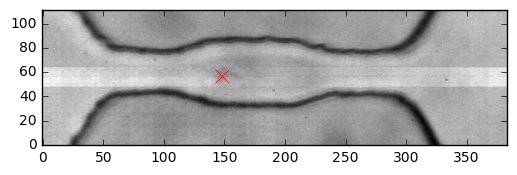

radius: 5.29637811814
aspect: 1.42030546157


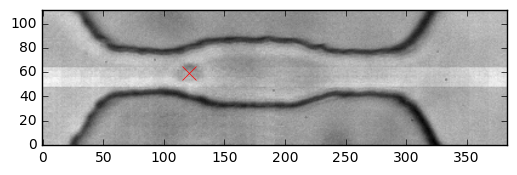

radius: 6.21338552328
aspect: 1.27210435536


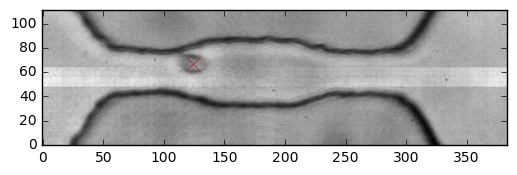

radius: 6.25616783786
aspect: 0.622886846191


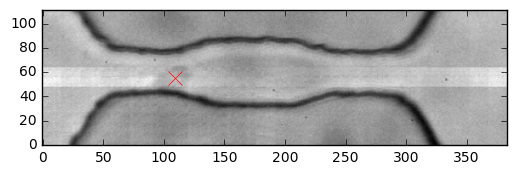

radius: 6.70951208799
aspect: 1.46559107382


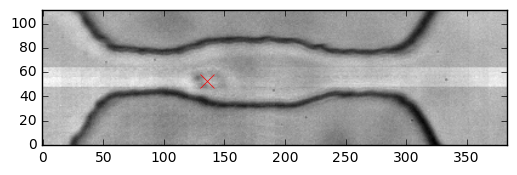

radius: 6.03360129496
aspect: 1.69662857299


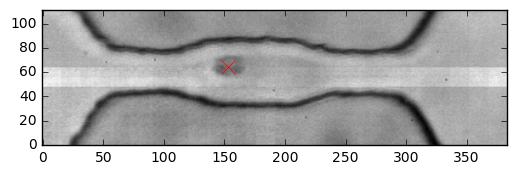

radius: 6.47811451542
aspect: 2.00237608945


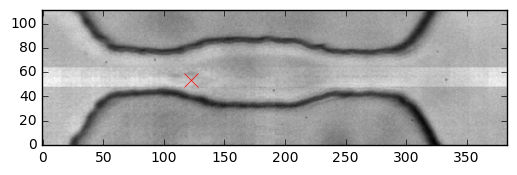

radius: 6.57181291822
aspect: 1.30546882898


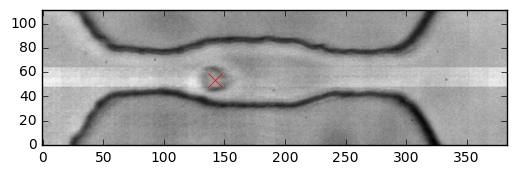

radius: 7.47465954614
aspect: 0.701089857436


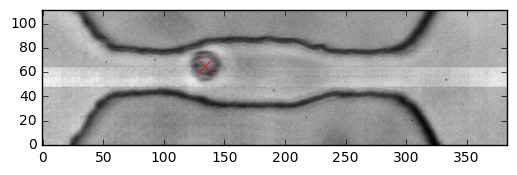

radius: 6.97621207472
aspect: 2.15115905889


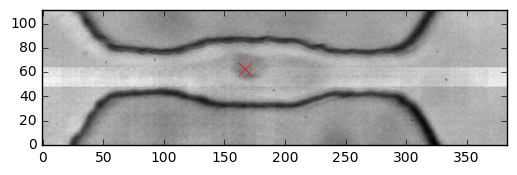

radius: 5.46501064409
aspect: 1.46415170192


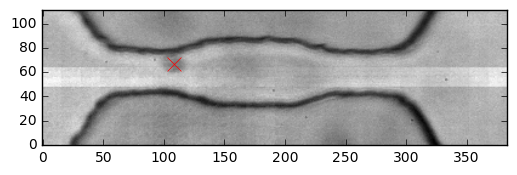

radius: 6.30367422122
aspect: 1.90092068302


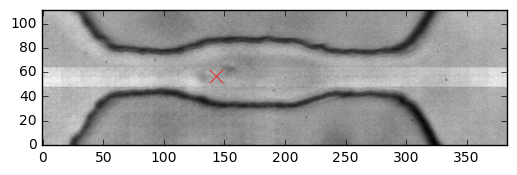

radius: 6.46987655067
aspect: 1.63757404143


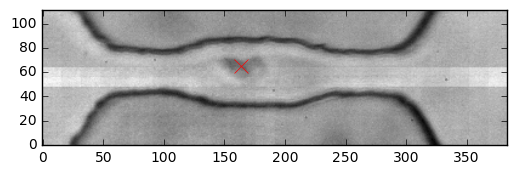

radius: 7.59714147117
aspect: 1.77258729072


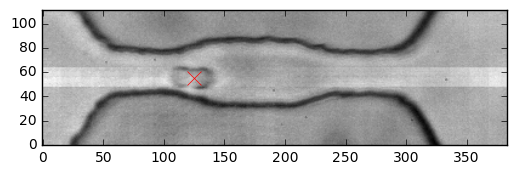

radius: 7.85903780462
aspect: 1.56430676937


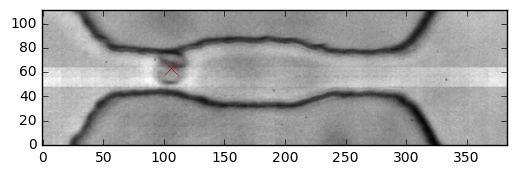

radius: 6.00918026334
aspect: 1.99226973491


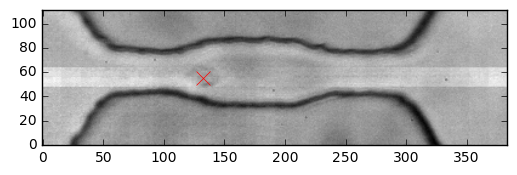

radius: 5.14104737893
aspect: 0


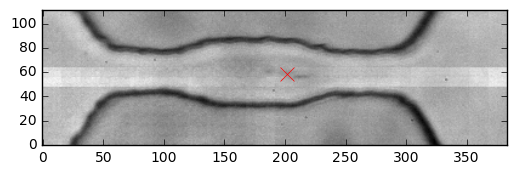

radius: 5.1546899523
aspect: 1.48127854738


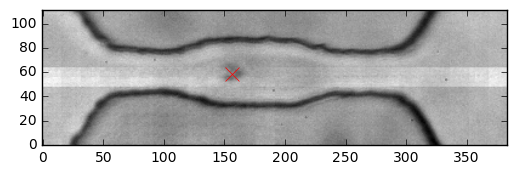

radius: 6.79536674622
aspect: 1.40482676293


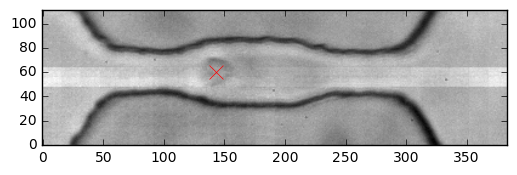

radius: 5.06668393613
aspect: 0.713706971328


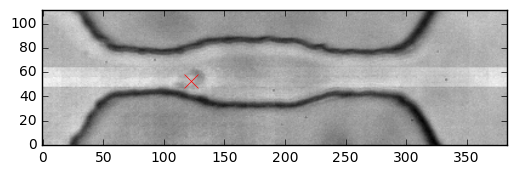

radius: 5.67832033235
aspect: 1.34143954609


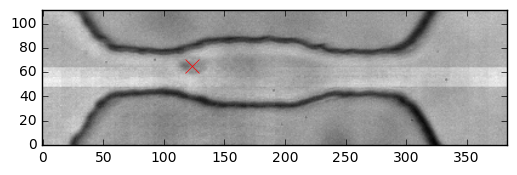

radius: 5.11334412428
aspect: 1.43067282065


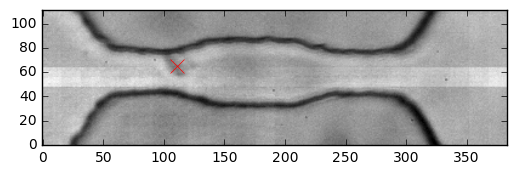

radius: 7.53322718811
aspect: 0.64763222744


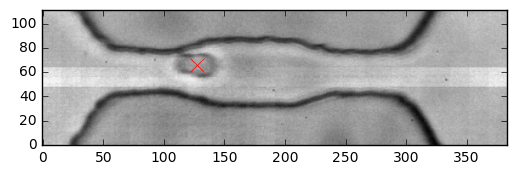

radius: 5.27255722968
aspect: 1.39095456091


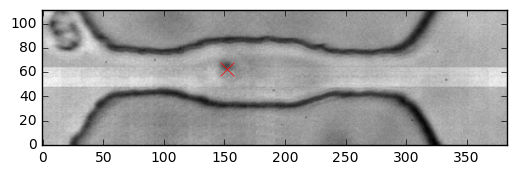

radius: 5.7991723747
aspect: 1.32993424357


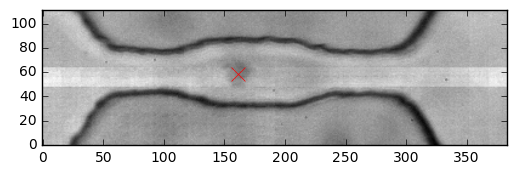

radius: 6.86382226305
aspect: 1.29524548707


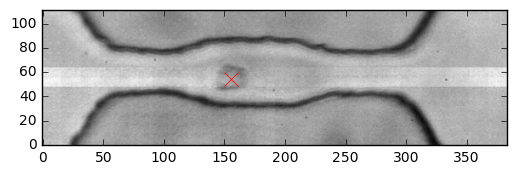

radius: 7.12815908165
aspect: 1.33976711262


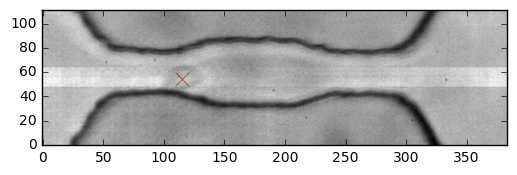

radius: 7.15539280621
aspect: 2.49376370381


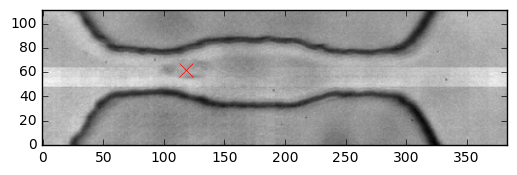

radius: 5.69207657795
aspect: 0.392838070978


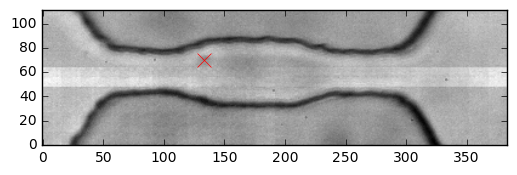

radius: 5.69130816575
aspect: 1.45403620198


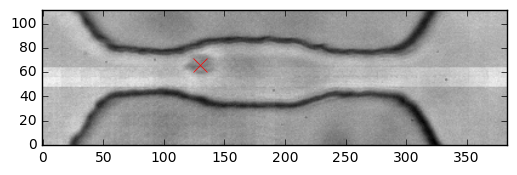

radius: 7.36956355201
aspect: 0.694494725347


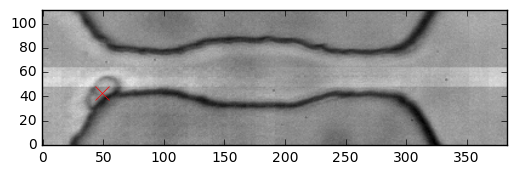

radius: 7.52458416154
aspect: 1.87276220707


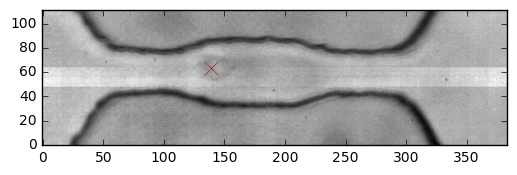

radius: 7.14152678628
aspect: 1.32413216208


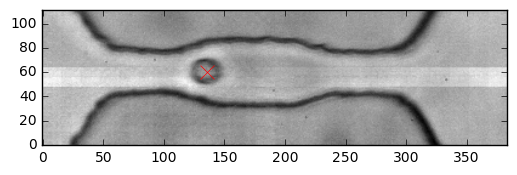

radius: 6.19107105906
aspect: 1.2737892874


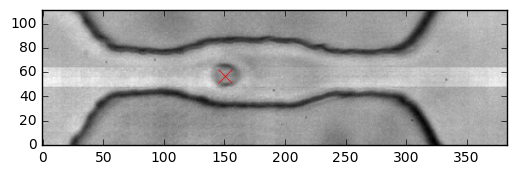

radius: 7.8470273627
aspect: 1.33393912342


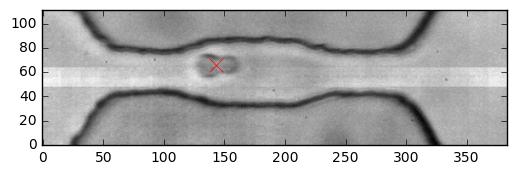

radius: 5.54907553571
aspect: 1.73479077923


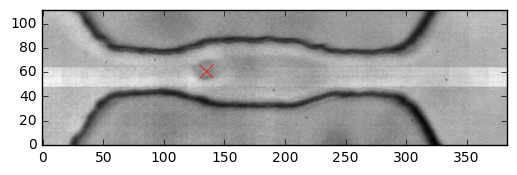

radius: 6.82537126976
aspect: 1.51444467848


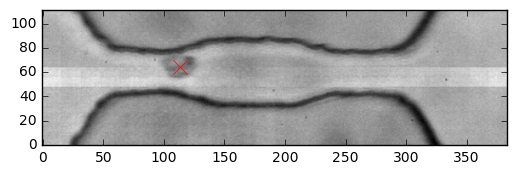

radius: 5.72118434448
aspect: 1.53683133877


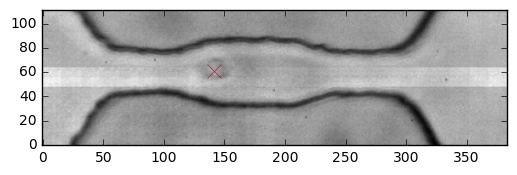

radius: 5.83889200864
aspect: 1.46555224035


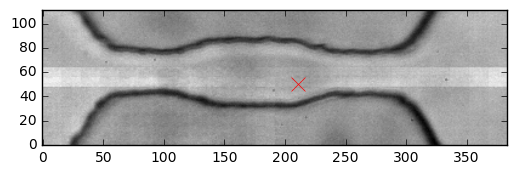

radius: 7.82362575326
aspect: 1.41120549633


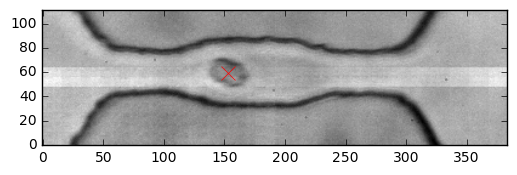

radius: 6.26342456917
aspect: 1.8431159104


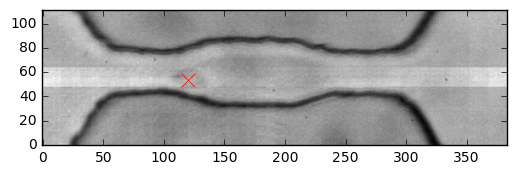

radius: 6.81708647163
aspect: 1.33086460944


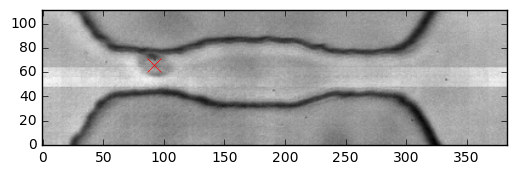

radius: 5.78561937456
aspect: 1.55919555489


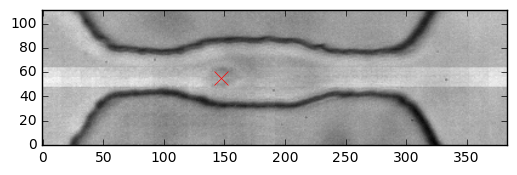

radius: 7.98202983054
aspect: 1.65040713573


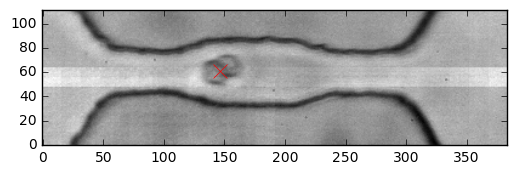

radius: 6.37342588081
aspect: 1.27738176856


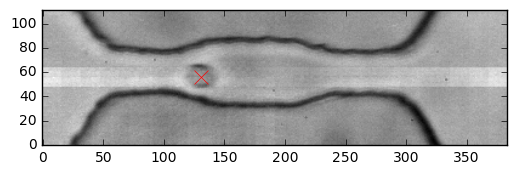

radius: 5.3405918191
aspect: 2.44756131341


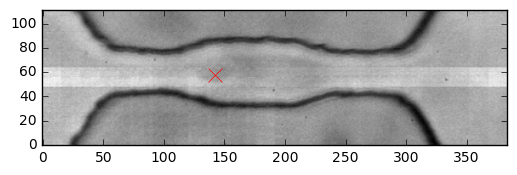

radius: 5.4119078805
aspect: 1.58117290127


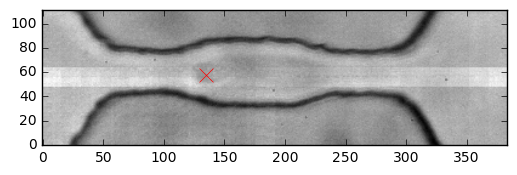

radius: 5.46581507986
aspect: 1.61829533788


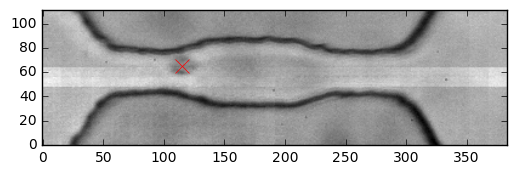

radius: 6.26905517956
aspect: 1.27890494054


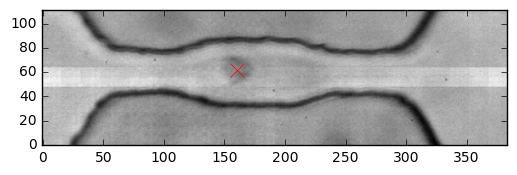

radius: 7.99816695677
aspect: 1.47760455771


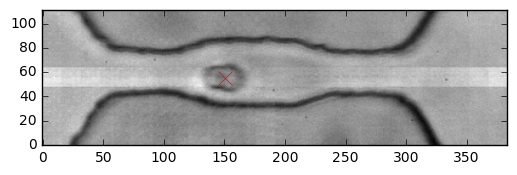

radius: 7.50692217152
aspect: 1.52545765073


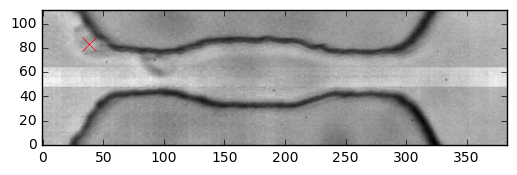

radius: 6.66565371672
aspect: 1.28552264392


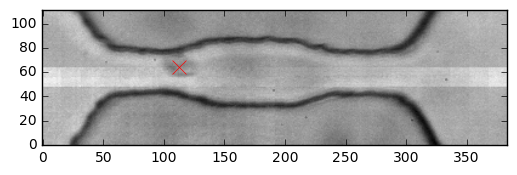

radius: 7.66514593119
aspect: 1.4550986737


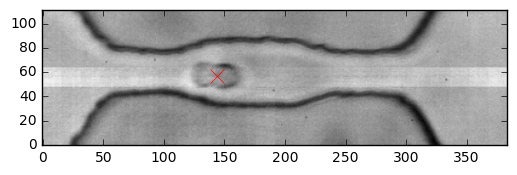

radius: 5.54714042728
aspect: 1.56553951901


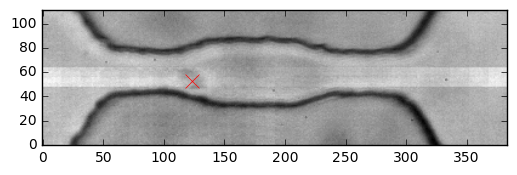

radius: 6.31384771899
aspect: 1.81174028508


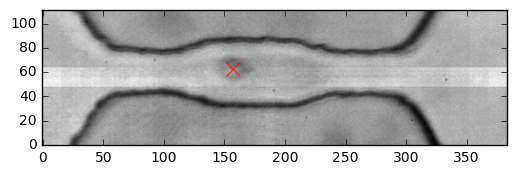

radius: 7.7151161032
aspect: 1.34220496948


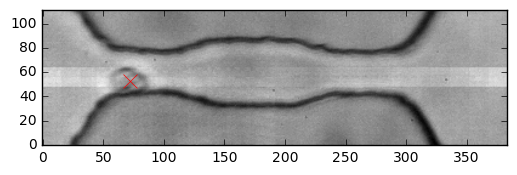

radius: 5.26317054496
aspect: 2.20144194722


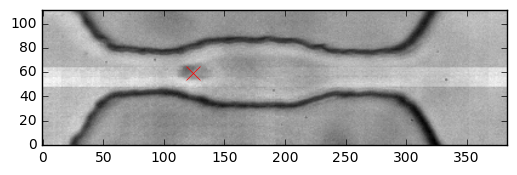

radius: 6.67579176417
aspect: 1.25262673178


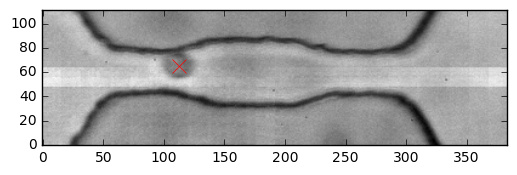

radius: 7.24297615527
aspect: 1.25189404703


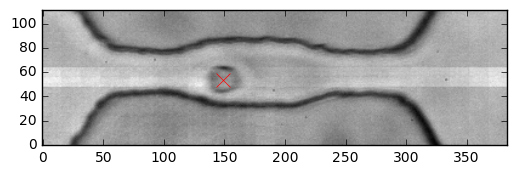

radius: 6.95900380862
aspect: 1.30035690018


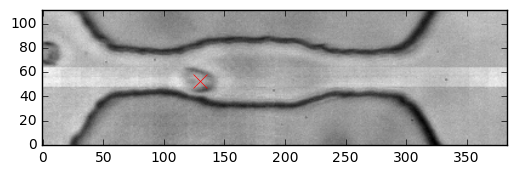

radius: 7.89711930141
aspect: 1.30385413983


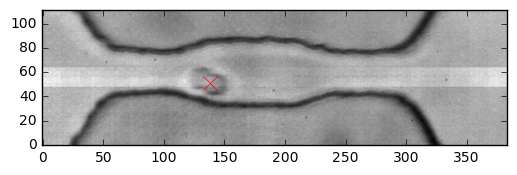

radius: 7.58096610643
aspect: 1.81070102257


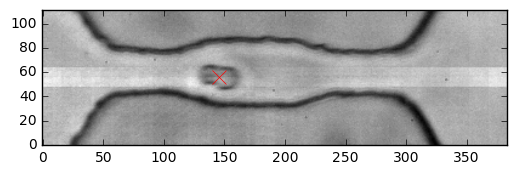

radius: 6.27339016078
aspect: 1.36273451543


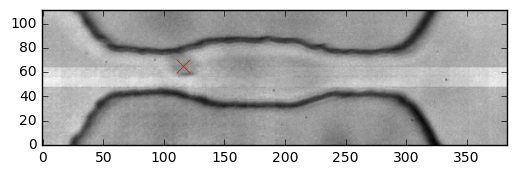

radius: 7.63034609704
aspect: 0.690670490631


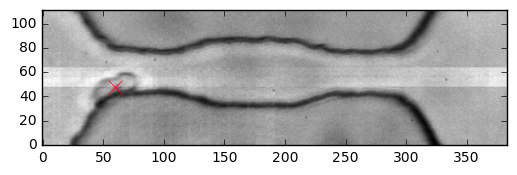

radius: 6.10730780403
aspect: 1.40186219795


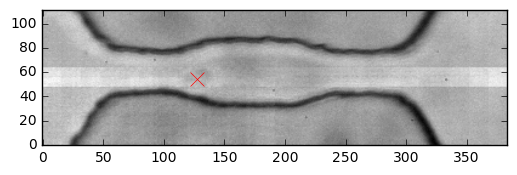

radius: 6.67329630789
aspect: 1.3544850943


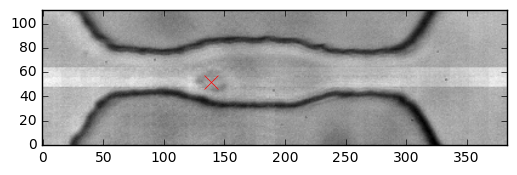

radius: 7.84667471563
aspect: 1.66431096418


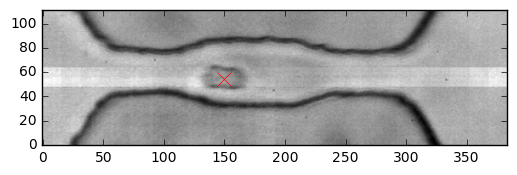

radius: 7.20551749889
aspect: 1.67530628242


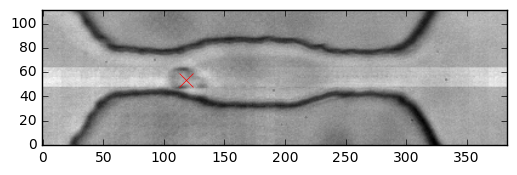

radius: 7.09729789267
aspect: 1.27993465294


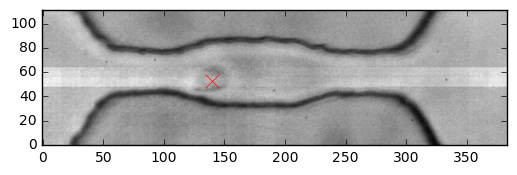

In [30]:
oi_indices = [7, 10, 66, 68, 77, 82, 93, 101, 106, 121, 122, 137, 147, 162, 171, 194, 213, 248, 252, 279, 286, 316, 374, 388, 402, 425, 432, 446, 457, 465, 474, 499, 525, 526, 537, 549, 551, 556, 589, 605, 672, 681, 684, 714, 729, 749, 770, 783, 784, 798, 811, 838, 847, 849, 895, 905, 912, 954, 975, 978, 981, 990, 991, 1020, 1030, 1037, 1039, 1071, 1090, 1093, 1102, 1106, 1107, 1119, 1121]
for oi_index in oi_indices:

    print 'radius:', effective_radii[oi_index]
    print 'aspect:', aspect_ratios[oi_index]

    oi_event = oi_events[oi_index]
    ts = oi_event.get_tf()
    t = int((ts[-1] + ts[0])/2.)
    detection_index = t - ts[0]
    detection = oi_event._detections[detection_index]
    x = detection._px
    y = detection._py
    frame = oi_vid.get_frame(t)
    plt.scatter(x, y, marker = 'x', s = 100, color = 'red', lw = 0.5)

    plt.imshow(frame, cmap = 'gray', origin = 'lower')
    plt.show()

In [33]:
oi_index = 905
print 'radius = ', effective_radii[oi_index]
print 'aspect = ', aspect_ratios[oi_index]
reload(oi_file)
plt.close()
HTML(oi_file.make_animation(oi_vid, oi_events[oi_index]._detections[0]._tf, oi_events[oi_index]._detections[-1]._tf, oi_fps).to_html5_video())

radius =  7.99816695677
aspect =  1.47760455771


### y-based filtering

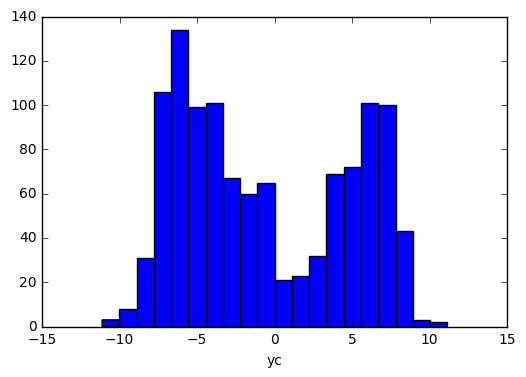

In [35]:
# Central cavity y-based filtering

yc_middles = []
yc_failed_indices = []

# Set yc_middle_min and max... These are bounds that we do not accept events outside of. Usually if there is
# a really bad fit, the detected yc value could be something like -60. This is unphysical, so we 
# manually introduce yc_middle_min and yc_middle_max to filter out unphysical values.
yc_middle_min = -25
yc_middle_max = 25

for i, oi_event in enumerate(oi_events):
    
    try:
        # Calculation sometimes fails, put in a 'try' block
        
        
        # Get positions of ellipses and convert to channel micron units
        xs = [ellipse[1] for ellipse in ellipsess[i]]
        ys = [ellipse[2] for ellipse in ellipsess[i]]
    
        
        xcs, ycs = oi_stage.get_channel_coordinates(xs, ys)
        xcs = oi_stage.pixels_to_meters(xcs)
        ycs = oi_stage.pixels_to_meters(ycs)
        

        # Interpolate the indices of x-positions
        is_interp = scipy.interpolate.interp1d(xcs, range(len(xcs)))
    
    
        # Get the index closest to the middle of the channel
        i_middle = int(is_interp(oi_stage._length_microns/2.))
        
        
        
        yc_middle = ycs[i_middle]
        
        
        if yc_middle > yc_middle_max or yc_middle < yc_middle_min:
            # The determined yc_middle is outside the manual bounds we set above; raise a ValueError
            # to exit try statement and go to except.
            print 'value error'
            raise ValueError
    
        yc_middles.append(ycs[i_middle])
        
    except:
        # Calculation failed, add the index to the yc_failed_indices which will automatically be rejected
        # later on.
        print 'failed', i
        yc_failed_indices.append(i)
        yc_middles.append(-500)
    



    
# Apply offset to y so centered at 0... only count the successes
yc_middles = np.array(yc_middles)
yc_success_indices = np.array([i for i in range(len(oi_events)) if i not in yc_failed_indices])
offset = -(np.max(yc_middles[yc_success_indices]) - np.abs(np.min(yc_middles[yc_success_indices])))/2.
yc_middles = np.array(yc_middles)
yc_middles = yc_middles + offset



# Plot hist of all ys
plt.hist(yc_middles[yc_success_indices], bins = 20)
plt.xlabel('yc')
plt.show()



In [36]:
yc_threshold = 3
filtering_steps['yc cavity threshold'] = [yc_threshold]

keep_indices_y = np.where(np.abs(yc_middles) <= yc_threshold)[0]
keep_indices_y = [keep_index_y for keep_index_y in keep_indices_y if keep_index_y not in yc_failed_indices]

print 'length before', len(oi_events), 'length after', len(keep_indices_y)
print
print 'events filtered by y', [i for i in range(len(ellipsess)) if i not in keep_indices_y]
print
print 'events kept by y', [i for i in range(len(ellipsess)) if i in keep_indices_y]

length before 1140 length after 232

events filtered by y [3, 4, 6, 7, 13, 14, 15, 16, 17, 18, 19, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 36, 38, 39, 40, 41, 42, 43, 44, 45, 46, 48, 49, 50, 54, 55, 57, 58, 60, 61, 62, 64, 65, 66, 68, 69, 70, 71, 72, 73, 74, 75, 77, 78, 79, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 94, 96, 97, 99, 100, 104, 106, 107, 108, 109, 112, 113, 114, 115, 116, 117, 118, 119, 121, 122, 123, 124, 125, 126, 127, 128, 129, 133, 134, 136, 137, 138, 139, 140, 141, 142, 143, 144, 147, 148, 149, 150, 151, 152, 154, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 168, 169, 171, 172, 173, 174, 175, 177, 178, 179, 180, 181, 183, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 196, 197, 198, 199, 200, 202, 203, 204, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 230, 231, 232, 233, 234, 235, 236, 237, 238, 240, 241, 242, 244, 247, 249, 251, 252, 253, 254, 255, 257, 258, 259, 

In [40]:
oi_index = 2
print 'radius', effective_radii[oi_index]
print 'aspect', aspect_ratios[oi_index]
print 'yc middle', yc_middles[oi_index]
reload(oi_file)
plt.close()
HTML(oi_file.make_animation(oi_vid, oi_events[oi_index]._detections[0]._tf, oi_events[oi_index]._detections[-1]._tf, oi_index).to_html5_video())

radius 6.75875590386
aspect 1.02186857383
yc middle -1.60370810777


## Manual filtering
- Inspect the events that haven't been filtered out yet to make sure they are good.
- Add undesirable events to the 'manual_remove_indices' list

In [41]:
keep_indices = [i for i in range(len(oi_events)) if ((i in keep_indices_enter_exit)\
                                                     and (i in keep_indices_radius)\
                                                     and (i in keep_indices_aspect)\
                                                     and (i in keep_indices_y))]

print 'keeping', len(keep_indices), '/', len(ellipsess), 'events before manual removal'
print 'events to be kept:', keep_indices

keeping 153 / 1140 events before manual removal
events to be kept: [1, 2, 8, 9, 11, 20, 35, 47, 51, 52, 59, 63, 95, 102, 103, 105, 110, 111, 120, 130, 132, 145, 146, 153, 155, 167, 170, 176, 184, 195, 201, 205, 229, 239, 243, 245, 246, 250, 256, 261, 270, 278, 285, 302, 305, 308, 318, 322, 339, 349, 353, 389, 391, 393, 411, 414, 415, 433, 437, 442, 451, 455, 477, 486, 492, 496, 511, 520, 536, 539, 542, 546, 550, 558, 559, 582, 593, 604, 617, 619, 622, 626, 631, 647, 650, 658, 663, 674, 678, 686, 694, 695, 705, 711, 716, 727, 743, 758, 767, 772, 794, 809, 824, 832, 836, 879, 880, 885, 889, 897, 915, 922, 923, 926, 928, 931, 933, 935, 940, 943, 947, 950, 952, 953, 965, 968, 998, 1006, 1013, 1016, 1025, 1031, 1033, 1035, 1036, 1038, 1043, 1048, 1051, 1056, 1058, 1061, 1070, 1072, 1075, 1076, 1085, 1111, 1114, 1124, 1135, 1136, 1139]


##### Inspect frame

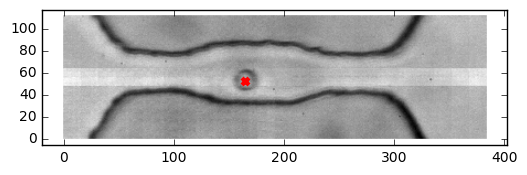

In [43]:
oi_index = 50
oi_event = oi_events[oi_index]
detection_index = int(len(oi_event._detections)/2.)
t = oi_event._detections[detection_index]._tf
frame = oi_vid.get_frame(t)
plt.imshow(frame, cmap = 'gray', origin = 'lower')


plt.scatter(oi_event._detections[detection_index]._px, oi_event._detections[detection_index]._py,\
            marker = 'x', c = 'red', lw = 3, s = 25)
plt.show()

##### Inspect video

In [44]:
oi_index = 212

print 'radius:', effective_radii[oi_index]
print 'aspect:', aspect_ratios[oi_index]
print 'yc:', yc_middles[oi_index]

reload(oi_file)
plt.close()
HTML(oi_file.make_animation(oi_vid, oi_events[oi_index]._detections[0]._tf, oi_events[oi_index]._detections[-1]._tf, oi_index).to_html5_video())

radius: 8.68884303335
aspect: 1.28592248504
yc: -6.49970872661


In [45]:
manual_remove_indices = []

filtering_steps['manual removal'] = [len(manual_remove_indices)]

print 'manually removing indices', manual_remove_indices

keep_indices_manual = [i for i in range(len(oi_events)) if i not in manual_remove_indices]

manually removing indices []


## Filtering step

In [46]:
keep_indices = [i for i in range(len(oi_events)) if ((i in keep_indices_enter_exit)\
                                                     and (i in keep_indices_radius)\
                                                     and (i in keep_indices_aspect)\
                                                     and (i in keep_indices_y)\
                                                    and (i in keep_indices_manual))]


print(keep_indices)
print('filtering ' + str(len(oi_events) - len(keep_indices)) + ' out of ' + str(len(oi_events)) + ' events')

[1, 2, 8, 9, 11, 20, 35, 47, 51, 52, 59, 63, 95, 102, 103, 105, 110, 111, 120, 130, 132, 145, 146, 153, 155, 167, 170, 176, 184, 195, 201, 205, 229, 239, 243, 245, 246, 250, 256, 261, 270, 278, 285, 302, 305, 308, 318, 322, 339, 349, 353, 389, 391, 393, 411, 414, 415, 433, 437, 442, 451, 455, 477, 486, 492, 496, 511, 520, 536, 539, 542, 546, 550, 558, 559, 582, 593, 604, 617, 619, 622, 626, 631, 647, 650, 658, 663, 674, 678, 686, 694, 695, 705, 711, 716, 727, 743, 758, 767, 772, 794, 809, 824, 832, 836, 879, 880, 885, 889, 897, 915, 922, 923, 926, 928, 931, 933, 935, 940, 943, 947, 950, 952, 953, 965, 968, 998, 1006, 1013, 1016, 1025, 1031, 1033, 1035, 1036, 1038, 1043, 1048, 1051, 1056, 1058, 1061, 1070, 1072, 1075, 1076, 1085, 1111, 1114, 1124, 1135, 1136, 1139]
filtering 987 out of 1140 events


# Save
- Save the filtering parameters as well as the indices of the events to be kept

### Save filtering parameters and indices

In [47]:
output_file_path = '../data/' + date + particle + channel + file_index + '/filter'
print 'saving to ', output_file_path


with open(output_file_path, 'w') as file_handle:
    file_writer = csv.writer(file_handle, delimiter = '\t')
    
    
    # Write filtering steps
    for filtering_step in filtering_steps:
        file_writer.writerow(['filter step', filtering_step, filtering_steps[filtering_step]])
        
    file_writer.writerow(['events'] + keep_indices)

saving to  ../data/10-10-2017/HCT-116_1/10-20-10_1/0/filter
